# MentalRiskES@IberLEF2023 - AutoML 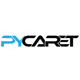

## Import libraries

In [1]:
# -- Install libraries
!pip install llvmlite --ignore-installed
!pip install pycaret -U
!pip install empath
!python -m spacy download en_core_web_sm
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 27.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.2 requires llvmlite<0.39,>=0.38.0rc1, but you have llvmlite 0.39.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 12.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# -- Libraries
from   sklearn.feature_extraction.text import TfidfVectorizer
from   nltk.stem                       import WordNetLemmatizer
from   tqdm                            import tqdm
from   empath                          import Empath
from   codecarbon                      import EmissionsTracker
import matplotlib.pyplot               as plt
import seaborn                         as sns
import pandas                          as pd
import numpy                           as np
import json
import pickle
import spacy
import nltk
import re

config = {
    "save_to_file": True,
    "log_level": "DEBUG",
    "tracking_mode": "process",
    "output_dir": ".",
}
tracker = EmissionsTracker(**config)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('display.max_columns', None)
tqdm.pandas()

[codecarbon INFO @ 17:09:39] [setup] RAM Tracking...
[codecarbon INFO @ 17:09:39] [setup] GPU Tracking...
[codecarbon INFO @ 17:09:39] No GPU found.
[codecarbon INFO @ 17:09:39] [setup] CPU Tracking...
[codecarbon DEBUG @ 17:09:39] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon DEBUG @ 17:09:39] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Intel RAPL files not found at /sys/class/powercap/intel-rapl on linux
[codecarbon WARNING @ 17:09:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:09:40] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 17:09:40] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 17:09:40] >>> Tracker's metadata:
[codecarbon INFO @ 17:09:40]   Platform system: Linux-5.15.109+-x86_64-with-debi

## Load file from previous notebook

In [3]:
df = pd.read_csv('/kaggle/input/mental-risk-2023-helsinki-train/mental_risk_2023_helsinki_train.csv')
df.reset_index(drop=True, inplace=True)
df.shape

(6865, 152)

__List of features__

In [3]:
# -- Empath features
emote_list = list(set(['hate', 'envy', 'health', 'nervousness', 'weakness', 'horror', 'suffering', 'kill', 'fear', 'friends', 'sexual', 'body', 'family',
                       'irritability','violence','sadness','disgust','exasperation','emotional','anger','poor','pain','timidity','cheerfulness', 'night', 'college', 'sports', 'neglect',
                       'medical_emergency','rage','alcohol','positive_emotion','negative_emotion','ugliness','weapon','shame','torment','office','help',
                       'sleep', 'money', 'school', 'home', 'hygiene', 'phone', 'work', 'appereance', 'optimism', 'youth', 'joy', 'valuable', 'swearing_terms',
                       'disappointment', 'children', 'contentment', 'music', 'musical', 'deception', 'blue_collar_job', 'clothing', 'white_collar_job', 'exercise']))
# -- POS features
pos_features_list = ['fe_pos_adjs', 'fe_pos_advs', 'fe_pos_verbs', 'fe_pos_nouns', 'fe_pos_past_tense_verbs']

# -- Subjectivity and polarity - ROUND
sub_pol_list = ['fe_subjectivity', 'fe_polarity']

# -- Text features 
text_features_list = ['fe_punct_signs', 'fe_number_uppercase_words', 'fe_num_first_person_pronouns', 'fe_num_antidepressants', 'fe_num_words', 'fe_num_sentences', 'fe_num_paragraphs', 'fe_num_long_words', 'fe_num_complex_words', 'fe_num_emojis_emoticons', 'fe_num_negations', 'fe_num_pos_emojis', 'fe_num_neut_emojis', 'fe_num_neg_emojis']

# -- Date features
date_features = ['fe_posted_early_morning', 'fe_posted_morning', 'fe_posted_afternoon', 'fe_posted_night', 'fe_posted_first_season', 'fe_posted_second_season', 'fe_posted_third_season', 'fe_posted_fourth_season']

# -- Readability index
readability_list = ['fe_kincaid_readability_index', 'fe_ari_readability_index', 'fe_coleman_readability_index', 'fe_flesch_readability_index', 'fe_gunning_fog_readability_index', 'fe_lix_readability_index', 'fe_smog_index']

# -- Depression terms
terms_list = ['fe_num_anhedonia_terms', 'fe_num_concentration_terms', 'fe_num_eating_terms', 'fe_num_fatigue_terms', 'fe_num_mood_terms', 'fe_num_psychomotor_terms', 'fe_num_self-esteem_terms', 'fe_num_self-harm_terms', 'fe_num_sleep_disorder_terms', 'fe_num_panic_attacks_terms']

# -- Transformers - Sentiment - ROUND
sentiment_list = ['fe_roberta_base_sentiment_negative', 'fe_roberta_base_sentiment_neutral', 'fe_roberta_base_sentiment_positive', 'fe_vader_positive_sentiment', 'fe_vader_neutral_sentiment', 'fe_vader_negative_sentiment']

# -- Transformers - Emotion - ROUND
emotion_list = ['fe_distilbert_emotion_optimism', 'fe_distilbert_emotion_joy', 'fe_distilbert_emotion_sadness', 'fe_distilbert_emotion_anger', 'fe_nrclex_emotion_fear', 'fe_nrclex_emotion_anger', 'fe_nrclex_emotion_anticip', 'fe_nrclex_emotion_trust', 'fe_nrclex_emotion_surprise', 'fe_nrclex_emotion_positive', 'fe_nrclex_emotion_negative', 'fe_nrclex_emotion_sadness', 'fe_nrclex_emotion_disgust', 'fe_nrclex_emotion_joy']

# -- Transformers - Toxic - ROUND
toxic_list = ['fe_toxic', 'fe_severe_toxic', 'fe_obscene', 'fe_threat', 'fe_insult', 'fe_identity_hate']

## Group users

In [5]:
df.rename(columns={'fe_vader_positive_sentiment_aux': 'fe_vader_positive_sentiment',
                   'fe_vader_neutral_sentiment_aux': 'fe_vader_neutral_sentiment',
                   'fe_vader_negative_sentiment_aux': 'fe_vader_negative_sentiment',
                   'user_id': 'Subject_ID', 'index': 'Subject_ID'}, inplace=True)

In [6]:
label_rounded_list = []
for label in tqdm([sub_pol_list + sentiment_list + emotion_list + toxic_list][0]):
    if label in df.columns:
        df[label + '_rounded'] = df[label].apply(lambda x: int(np.round(x)))
        label_rounded_list.append(label + '_rounded')

100%|██████████| 28/28 [00:01<00:00, 23.62it/s]


In [7]:
df = df.drop_duplicates(subset=['Subject_ID', 'Text', 'Class'])
df.reset_index(drop=True, inplace=True)

Group by user:

* Sentiment + Emotion + Toxicity + Subjectivity/Polarity + Readability: __mean__
* Rest of features: __sum__

In [8]:
df_grouped = df.groupby(['Subject_ID', 'Class'])[emote_list + pos_features_list + text_features_list + date_features + terms_list].apply(lambda x : x.astype(int).sum()).reset_index().merge(
                            df.groupby(['Subject_ID', 'Class'])[readability_list].apply(lambda x : x.mean()).reset_index(),
                            on=['Subject_ID', 'Class']
                        ).merge(
                            df.groupby(['Subject_ID', 'Class'])[[label for label in [sentiment_list + emotion_list + toxic_list + sub_pol_list][0]]].apply(lambda x : x.mean()).reset_index()\
                              .rename(columns={label: label + "_mean" for label in [sentiment_list + emotion_list + toxic_list + sub_pol_list][0]}),
                            on=['Subject_ID', 'Class']
                        ).merge(
                            df.groupby(['Subject_ID', 'Class'])['Text'].apply(lambda x : "<NEW_REDDIT_POST>".join(x)).reset_index(),
                            on=['Subject_ID', 'Class']
                        )

In [9]:
df_grouped.shape

(185, 137)

__Finally, drop unused features__

In [10]:
df_grouped.drop(['Text', 'Subject_ID', 'fe_distilbert_emotion_anger_mean', 'fe_num_antidepressants'], axis=1, inplace=True)

In [11]:
df_grouped.shape

(185, 133)

## Auto-ML with PyCaret

In [ ]:
# -- AutoML:
# ---- Train size: 80 %
# ---- Only numeric features
# ---- Add feature selection (threshold = 0.9)
# ---- Fix imbalance
from pycaret.classification import *
pd.set_option('display.max_rows', None)
s = setup(data = df_grouped, train_size = 0.8, target = 'Class', numeric_features=[var for var in list(df_grouped.columns) if var != 'Class'], feature_selection_method='classic',
          categorical_features = [], session_id=1234, feature_selection=True, n_features_to_select=0.25, fix_imbalance=False)
best_model = compare_models(sort = 'F1', n_select=4, exclude=['lda', 'svm', 'et', 'nb', 'ridge'])

### Model explainability: SHAP values

In [ ]:
# -- Install libraries
!pip install llvmlite --ignore-installed
!pip install shap --upgrade
!pip install llvmlite --ignore-installed
!pip install numba==0.53
import shap

In [ ]:
model_index = 0
interpret_model(best_model[model_index])

In [ ]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(12,13))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], color='red')
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(best_model[model_index].feature_importances_, best_model[model_index].feature_names_in_,'Model feature importance')

__Save best models__

In [ ]:
# Save best models
for model, model_name in zip(best_model, ['rf', 'gbc', 'lightgbm', 'lr']):
    with open('{}_2023_05_13_google_translator.pkl'.format(model_name), 'wb') as f:
        pickle.dump(model, f)

## Error analysis

In [ ]:
df_grouped_class1 = df_grouped[df_grouped['Class'] == 1]

In [ ]:
df_grouped_class1['non_depressed_proba'] = best_model[model_index].predict_proba(df_grouped_class1[list(best_model[model_index].feature_name_)])[:,0]
df_grouped_class1['depressed_proba'] = best_model[model_index].predict_proba(df_grouped_class1[list(best_model[model_index].feature_name_)])[:,1]
index_list = list(df_grouped_class1[(df_grouped_class1['depressed_proba'] >= 0.5)].sort_values('non_depressed_proba').index)

In [ ]:
explainer   = shap.TreeExplainer(model=best_model[model_index])
shap_values = explainer.shap_values(df_grouped[list(best_model[model_index].feature_name_)])

In [ ]:
df_grouped_class1[df_grouped_class1['depressed_proba'] >= 0.5][['non_depressed_proba', 'depressed_proba']].head()

In [ ]:
index = 6
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][index], df_grouped[list(best_model[model_index].feature_name_)].iloc[index,:])

In [ ]:
df_grouped = df.groupby(['Subject_ID', 'Class'])[emote_list + pos_features_list + text_features_list + date_features + terms_list].apply(lambda x : x.astype(int).sum()).reset_index().merge(
                            df.groupby(['Subject_ID', 'Class'])[readability_list].apply(lambda x : x.astype(int).mean()).reset_index(),
                            on=['Subject_ID', 'Class']
                        ).merge(
                            df.groupby(['Subject_ID', 'Class'])[[label for label in [sentiment_list + emotion_list + toxic_list + sub_pol_list][0]]].apply(lambda x : x.mean()).reset_index()\
                              .rename(columns={label: label + "_mean" for label in [sentiment_list + emotion_list + toxic_list + sub_pol_list][0]}),
                            on=['Subject_ID', 'Class']
                        ).merge(
                            df.groupby(['Subject_ID', 'Class'])['Text'].apply(lambda x : "<NEW_REDDIT_POST>".join(x)).reset_index(),
                            on=['Subject_ID', 'Class']
                        )

In [ ]:
print(df_grouped.loc[index, 'Text'])